In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm

In [2]:
path_estreams = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_part_b\data\EStreams'

In [3]:
network_estreams = pd.read_csv(path_estreams+'\streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,9497,0.0,0.0,9497.0,0.0,B,[CH000197],1,16,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,[CH000221],1,1,[AT000002]
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,13513,0.0,0.0,13513.0,0.0,B,[CH000215],1,2,"[AT000002, AT000003, CH000221]"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,8765,0.0,0.0,8765.0,0.0,B,[CH000227],1,1,[AT000004]
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10957,0.0,0.0,10957.0,0.0,B,[CH000214],1,3,"[AT000005, CH000214]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1988,1,[UAGR0017]
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1989,1,[UAGR0018]
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1990,1,[UAGR0019]


In [4]:
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

nested_catchments

,nested_catchments
basin_id,
AT000001,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,[AT000002]
AT000003,"[AT000002, AT000003, CH000221]"
AT000004,[AT000004]
AT000005,"[AT000005, CH000214]"
...,...
UAGR0017,[UAGR0017]
UAGR0018,[UAGR0018]
UAGR0019,[UAGR0019]


In [5]:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 
estreams_attributes

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,0.127,23.0,10.0,10.0,6.62,542.33,33.844,23.025,29.307,22.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,0.040,4.0,4.0,3.0,1.46,12.91,36.927,0.000,0.204,18.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.023,1.0,1.0,1.0,0.89,8.27,34.486,0.000,0.084,10.0
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,0.058,7.0,6.0,5.0,2.67,23.90,32.887,0.000,0.399,40.0
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.016,0.0,0.0,0.0,0.00,0.00,27.201,0.000,0.000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,0.000,0.0,0.0,95.0,29.74,124.55,8.705,163.532,152.585,4.0
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,0.000,0.0,0.0,1.0,1.43,16.43,3.805,0.000,0.000,3.0
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,0.000,0.0,0.0,1.0,0.31,1.54,4.928,0.000,0.000,1.0


In [6]:
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [7]:
from utils.functions import find_max_unique_rows

# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

estreams_attributes_dfs["DEBU1959"]

100%|██████████| 1/1 [00:00<00:00, 474.09it/s]


,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.566,0.0,0.0,0.0,0.00,0.00,7.497,1.400,3.429,16.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,0.585,0.0,0.0,0.0,0.00,0.00,8.920,0.000,0.075,8.0
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,0.577,0.0,0.0,0.0,0.00,0.00,6.106,0.000,0.000,6.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.640,0.0,0.0,0.0,0.00,0.00,7.096,1.200,2.427,9.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,0.661,0.0,0.0,0.0,0.00,0.00,6.996,0.200,0.605,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,0.544,1.0,1.0,2.0,1.80,62.62,5.680,0.045,0.045,25.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.489,0.0,0.0,0.0,0.00,0.00,2.863,0.004,0.009,15.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,0.567,2.0,2.0,6.0,2.67,67.85,4.753,1.641,4.770,78.0


In [8]:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]
estreams_attributes_clipped

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.566,0.0,0.0,0.0,0.00,0.00,7.497,1.400,3.429,16.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,0.585,0.0,0.0,0.0,0.00,0.00,8.920,0.000,0.075,8.0
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,0.577,0.0,0.0,0.0,0.00,0.00,6.106,0.000,0.000,6.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.640,0.0,0.0,0.0,0.00,0.00,7.096,1.200,2.427,9.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,0.661,0.0,0.0,0.0,0.00,0.00,6.996,0.200,0.605,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,0.544,1.0,1.0,2.0,1.80,62.62,5.680,0.045,0.045,25.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.489,0.0,0.0,0.0,0.00,0.00,2.863,0.004,0.009,15.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,0.567,2.0,2.0,6.0,2.67,67.85,4.753,1.641,4.770,78.0


In [152]:
estreams_attributes_clipped.start_date

basin_id
BEWA0066   1998-01-01
BEWA0067   1999-01-01
BEWA0087   1976-06-04
BEWA0106   1991-09-03
BEWA0107   1991-09-03
              ...    
LU000015   2002-01-01
LU000016   2002-01-01
LU000017   2002-01-01
LU000018   2002-01-01
LU000019   2002-01-01
Name: start_date, Length: 152, dtype: datetime64[ns]

In [139]:
# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])

In [153]:
estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

estreams_attributes_clipped_filters

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.566,0.0,0.0,0.0,0.00,0.00,7.497,1.400,3.429,16.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,0.585,0.0,0.0,0.0,0.00,0.00,8.920,0.000,0.075,8.0
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,0.577,0.0,0.0,0.0,0.00,0.00,6.106,0.000,0.000,6.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.640,0.0,0.0,0.0,0.00,0.00,7.096,1.200,2.427,9.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,0.661,0.0,0.0,0.0,0.00,0.00,6.996,0.200,0.605,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,0.544,1.0,1.0,2.0,1.80,62.62,5.680,0.045,0.045,25.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.489,0.0,0.0,0.0,0.00,0.00,2.863,0.004,0.009,15.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,0.567,2.0,2.0,6.0,2.67,67.85,4.753,1.641,4.770,78.0


In [178]:
estreams_attributes_clipped_filters.index.tolist()[0:30]

['BEWA0066',
 'BEWA0067',
 'BEWA0087',
 'BEWA0106',
 'BEWA0107',
 'BEWA0119',
 'DEBU1956',
 'DEBU1957',
 'DEBU1958',
 'DEBU1959',
 'DERP2003',
 'DERP2004',
 'DERP2005',
 'DERP2006',
 'DERP2007',
 'DERP2008',
 'DERP2010',
 'DERP2011',
 'DERP2013',
 'DERP2014',
 'DERP2015',
 'DERP2016',
 'DERP2017',
 'DERP2018',
 'DERP2021',
 'DERP2022',
 'DERP2023',
 'DERP2024',
 'DERP2027',
 'DERP2028']

In [227]:
import pandas as pd

# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Display the first few rows to inspect the structure
df.head()

,Unnamed: 0,catchment_1,catchment_2
0,0,AT000001,AT000013
1,1,AT000001,CH000026
2,2,AT000001,CH000042
3,3,AT000001,CH000092
4,4,AT000001,CH000185


In [ ]:
# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

# Display the cleaned dataframe structure
df

,basin_id,connected_basin_id
0,AT000001,AT000013
1,AT000001,CH000026
2,AT000001,CH000042
3,AT000001,CH000092
4,AT000001,CH000185


In [229]:
df

,basin_id,connected_basin_id
0,AT000001,AT000013
1,AT000001,CH000026
2,AT000001,CH000042
3,AT000001,CH000092
4,AT000001,CH000185
...,...,...
265408,UAGR0011,UAGR0014
265409,UAGR0012,UAGR0014
265410,UAGR0013,UAGR0012
265411,UAGR0013,UAGR0014


In [ ]:
from collections import defaultdict


def find_iterative_immediate_downstream(df, catchments):
    """
    Finds the immediate downstream connection for each basin using an iterative approach,
    starting from the largest (end-point) basins and moving backward.
    """
    # Step 0:
    # Filter the dataframe to include only rows where 'basin_id' is in the selected_catchments list
    #filtered_df = df[df['basin_id'].isin(catchments)]
    #df = filtered_df

    # Step 1: Identify the largest basins (those not in the 'basin_id' column but in 'connected_basin_id')
    all_basins = set(df['basin_id'])
    all_connections = set(df['connected_basin_id'])
    largest_basins = all_connections - all_basins  # Basins that are only in the 'connected_basin_id' column

    # Step 2: Create mapping of connections
    downstream_map = defaultdict(set)
    for _, row in df.iterrows():
        downstream_map[row['basin_id']].add(row['connected_basin_id'])

    # Step 3: Reverse mapping for upstream tracking
    upstream_map = defaultdict(set)
    for basin, downstreams in downstream_map.items():
        for d in downstreams:
            upstream_map[d].add(basin)

    # Step 4: Iteratively determine the immediate downstream basin for each catchment
    immediate_downstream = {}
    processing_order = sorted(all_basins, key=lambda x: x in largest_basins, reverse=True)  # Start from largest

    for basin in processing_order:
        if basin in downstream_map:
            possible_downstreams = downstream_map[basin] & set(catchments)
            if possible_downstreams:
                # Select the downstream basin that is already assigned, or the one with least upstreams
                chosen_downstream = min(possible_downstreams, key=lambda b: len(upstream_map[b]))
                immediate_downstream[basin] = chosen_downstream

    return immediate_downstream

In [254]:
selected_catchments = estreams_attributes_clipped_filters.index.tolist()

# Run the iterative function
iterative_immediate_downstream = find_iterative_immediate_downstream(df, selected_catchments)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])

In [231]:
catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR003253", # Luneville
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR003271", # Nomeny
                    "FR000171", # Metz
                    "FR003272", # Hanconcourt
                    "FR003283", # Rosselange
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "DEBU1957", #Fremersdorf
                    "FR003308", #Niedaltdorf
                    "FR003301", # Wittring
                    "FR003304", # Bliesbruck
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2017", # Hentern
                    "DEBU1958", # Trier
                    "DERP2024", # Kordel
                    "DERP2033", # Plein
                    "DEBU1959", # Cochem
                    "DERP2011", #Alsdorf 
                    "DERP2003", # Bollendorf
                    "DERP2007"] # Pruem

In [249]:
selected_catchments = catchments_ids

iterative_immediate_downstream = find_iterative_immediate_downstream(df, selected_catchments)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])
iterative_downstream_df

,basin_id,immediate_downstream_basin
0,FR003245,FR003249
1,FR003238,FR003249
2,FR000178,DEBU1956
3,FR000143,FR003253
4,FR003249,FR003265
...,...,...
211,FR000147,FR003253
212,FR000191,FR003304
213,FR003248,FR003249
214,FR003236,FR003237


In [250]:
catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR003253", # Luneville
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR003271", # Nomeny
                    "FR000171", # Metz
                    "FR003272", # Hanconcourt
                    "FR003283", # Rosselange
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "DEBU1957", #Fremersdorf
                    "FR003308", #Niedaltdorf
                    "FR003301", # Wittring
                    "FR003304", # Bliesbruck
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2017", # Hentern
                    "DEBU1958", # Trier
                    "DERP2024", # Kordel
                    "DERP2033", # Plein
                    "DEBU1959", # Cochem
                    "DERP2011", #Alsdorf 
                    "DERP2003", # Bollendorf
                    "DERP2007"] # Pruem

In [255]:

catchments_ids = estreams_attributes_clipped_filters.index.tolist()


# Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
topology_list = {basin: None for basin in catchments_ids}  # Default to None

# Filter DataFrame for relevant basin_ids and update topology
for _, row in iterative_downstream_df.iterrows():
    if row['basin_id'] in topology_list:
        topology_list[row['basin_id']] = row['immediate_downstream_basin']

In [256]:
topology_list

{'BEWA0066': 'BEWA0119',
 'BEWA0067': 'BEWA0066',
 'BEWA0087': 'LU000001',
 'BEWA0106': 'BEWA0066',
 'BEWA0107': 'BEWA0066',
 'BEWA0119': 'LU000005',
 'DEBU1956': 'DEBU1958',
 'DEBU1957': 'DEBU1958',
 'DEBU1958': 'DEBU1959',
 'DEBU1959': None,
 'DERP2003': 'LU000017',
 'DERP2004': 'LU000019',
 'DERP2005': 'DERP2004',
 'DERP2006': 'DERP2007',
 'DERP2007': 'LU000017',
 'DERP2008': 'DERP2007',
 'DERP2010': 'DERP2011',
 'DERP2011': 'LU000017',
 'DERP2013': 'FR000190',
 'DERP2014': 'FR000190',
 'DERP2015': 'DERP2014',
 'DERP2016': 'DEBU1958',
 'DERP2017': 'DERP2018',
 'DERP2018': 'DEBU1959',
 'DERP2021': 'DERP2022',
 'DERP2022': 'DERP2023',
 'DERP2023': 'DERP2024',
 'DERP2024': 'DEBU1959',
 'DERP2027': 'DERP2023',
 'DERP2028': 'DERP2029',
 'DERP2029': 'DEBU1959',
 'DERP2030': 'DEBU1959',
 'DERP2031': 'DEBU1959',
 'DERP2033': 'DEBU1959',
 'DERP2036': 'DEBU1959',
 'FR000124': 'FR000125',
 'FR000125': 'FR000128',
 'FR000128': 'FR003237',
 'FR000132': 'FR003236',
 'FR000137': 'FR000138',
 'FR00

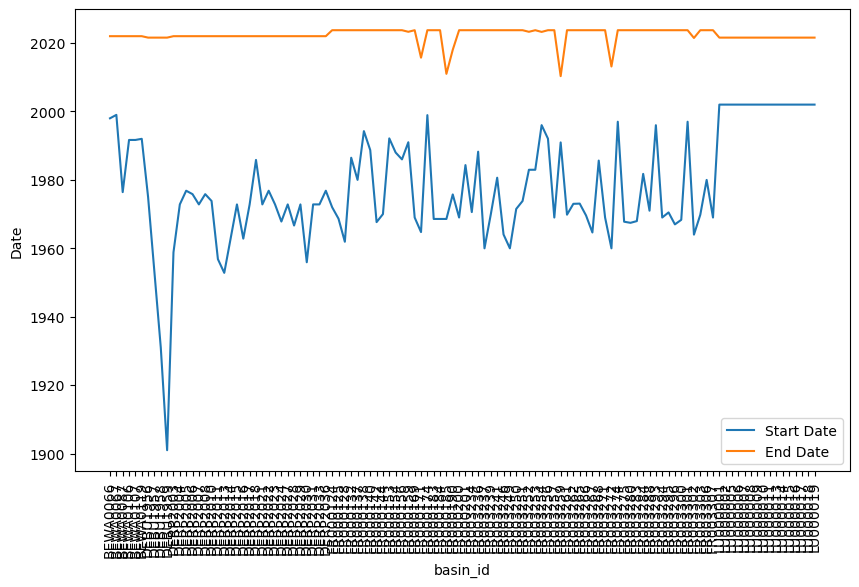

In [257]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot start_date and end_date on the same graph
estreams_attributes_clipped_filters.start_date.plot(ax=ax, label="Start Date")
estreams_attributes_clipped_filters.end_date.plot(ax=ax, label="End Date")

# Make y-axis label vertical
ax.set_ylabel("Date", rotation=90)

# Ensure ALL x-axis ticks are shown
ax.set_xticks(np.arange(len(estreams_attributes_clipped_filters)))  # Set all x-ticks
ax.set_xticklabels(estreams_attributes_clipped_filters.index, rotation=90)  # Rotate labels

# Add legend
ax.legend()

# Show plot
plt.show()


In [ ]:
#estreams_attributes_clipped_2 = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.gauges_upstream <= 1]
estreams_attributes_clipped_2 = estreams_attributes_clipped_filters.copy()


In [11]:
#basin_id = "FR000702"
#basin_id = "PL000700"
basin_id = "FR000154"
basin_id = "CH000001"
basin_id = "FR003237" # Epinal
#basin_id = "DERP2004" # GemuendOur
#basin_id = "DERP2007" # Pruemzurlay
basin_id = "DERP2023"
basin_id = "LU000011"
basin_id = "LU000001"
basin_id = "LU000007" #Ettelbruck
basin_id = "LU000015" #Michelau
basin_id = "DERP2004" 
#basin_id = "FR003237" # Epinal

#basin_id = "PT000102" 

#basin_id = "ITVE0429" 
#basin_id = "FR003253" # Luneville



In [12]:
"FR003237" # Epinal
"FR003249" # Toul
"FR003253" # Luneville
"FR000159" # Malzeville 
"FR003265" # Custines
"FR003271" # Nomeny
"FR000171" # Metz
"FR003272" # Hanconcourt
"FR003283" # Rosselange
"FR003275" # Boncourt
"DEBU1956" # Perl
"DEBU1957" #Fremersdorf
"FR003308" #Niedaltdorf
"FR003301" # Wittring
"FR003304" # Bliesbruck
"LU000007" #Ettelbruck
"DERP2004" # GemuendOur
"DERP2017" # Hentern
"DEBU1958" # Trier
"DERP2024" # Kordel
"DERP2033" # Plein
"DEBU1959" # Cochem
"DERP2011" #Alsdorf 
"DERP2003" # Bollendorf
"DERP2007" # Pruem

# Nalbach MISSING
# Reinheim MISSING


'DERP2007'

In [13]:
estreams_attributes_clipped.loc[basin_id, :].head(30)

gauge_id                                                      2626030300
gauge_name                                                    GemuendOur
gauge_country                                                         DE
gauge_provider                                                     DE_RP
river                                                                Our
lon_snap                                                           6.171
lat_snap                                                          49.985
lon                                                                6.171
lat                                                               49.985
elevation                                                            NaN
area_official                                                      613.4
area_estreams                                                      615.0
area_flag                                                              0
area_rel                                           

In [14]:
estreams_attributes_clipped.loc[basin_id, "baseflow_index":]

baseflow_index             0.5
hfd_mean               127.574
hfd_std                 19.292
q_5                      0.084
q_95                      4.65
                        ...   
lakes_tot_vol              0.0
sno_cov_mean             6.721
irri_1990                1.495
irri_2005                3.524
stations_num_p_mean       25.0
Name: DERP2004, Length: 86, dtype: object

In [15]:
estreams_attributes_clipped

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.566,0.0,0.0,0.0,0.00,0.00,7.497,1.400,3.429,16.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,0.585,0.0,0.0,0.0,0.00,0.00,8.920,0.000,0.075,8.0
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,0.577,0.0,0.0,0.0,0.00,0.00,6.106,0.000,0.000,6.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.640,0.0,0.0,0.0,0.00,0.00,7.096,1.200,2.427,9.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,0.661,0.0,0.0,0.0,0.00,0.00,6.996,0.200,0.605,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,0.544,1.0,1.0,2.0,1.80,62.62,5.680,0.045,0.045,25.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.489,0.0,0.0,0.0,0.00,0.00,2.863,0.004,0.009,15.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,0.567,2.0,2.0,6.0,2.67,67.85,4.753,1.641,4.770,78.0


In [ ]:
#catchments_ids = [
#    "FR003237", "DERP2004", "FR003253",'FR003249',
# 'LU000007'
#]


#catchments_ids = estreams_attributes_clipped[estreams_attributes_clipped.gauges_upstream <= 1].index.tolist()
catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR003253", # Luneville
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR003271", # Nomeny
                    "FR000171", # Metz
                    "FR003272", # Hanconcourt
                    "FR003283", # Rosselange
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "DEBU1957", #Fremersdorf
                    "FR003308", #Niedaltdorf
                    "FR003301", # Wittring
                    "FR003304", # Bliesbruck
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2017", # Hentern
                    "DEBU1958", # Trier
                    "DERP2024", # Kordel
                    "DERP2033", # Plein
                    "DEBU1959", # Cochem
                    "DERP2011", #Alsdorf 
                    "DERP2003", # Bollendorf
                    "DERP2007"] # Pruem

#catchments_ids = estreams_attributes_clipped[estreams_attributes_clipped.gauges_upstream <= 1].index.tolist()
catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR000171", # Metz
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "FR003301", # Wittring
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2024", # Kordel
                    "DEBU1959", # Cochem
                    "DERP2011"] #Alsdorf 

In [260]:
catchments_ids = ["DEBU1958", # Trier                    
                  "FR003272", # Hanconcourt
                  "DEBU1957", # Fremersdorf
                  "DERP2003", # Bollendorf
                  "FR003308", # Niedaltdorf
                  "FR003283", # Rosselange
                  "FR003253", # Luneville
                  "FR003271", # Nomeny
                  "DERP2033", # Plein
                  "DERP2017", # Hentern
                  "FR003304", # Bliesbruck
                  "DERP2007"] # Pruem



catchments_ids = estreams_attributes_clipped_2.index.tolist()


catchments_ids

['BEWA0066',
 'BEWA0067',
 'BEWA0087',
 'BEWA0106',
 'BEWA0107',
 'BEWA0119',
 'DEBU1956',
 'DEBU1957',
 'DEBU1958',
 'DEBU1959',
 'DERP2003',
 'DERP2004',
 'DERP2005',
 'DERP2006',
 'DERP2007',
 'DERP2008',
 'DERP2010',
 'DERP2011',
 'DERP2013',
 'DERP2014',
 'DERP2015',
 'DERP2016',
 'DERP2017',
 'DERP2018',
 'DERP2021',
 'DERP2022',
 'DERP2023',
 'DERP2024',
 'DERP2027',
 'DERP2028',
 'DERP2029',
 'DERP2030',
 'DERP2031',
 'DERP2033',
 'DERP2036',
 'FR000124',
 'FR000125',
 'FR000128',
 'FR000132',
 'FR000137',
 'FR000138',
 'FR000140',
 'FR000142',
 'FR000144',
 'FR000153',
 'FR000154',
 'FR000156',
 'FR000159',
 'FR000169',
 'FR000171',
 'FR000174',
 'FR000183',
 'FR000184',
 'FR000185',
 'FR000190',
 'FR000200',
 'FR000201',
 'FR003234',
 'FR003236',
 'FR003237',
 'FR003239',
 'FR003241',
 'FR003246',
 'FR003249',
 'FR003250',
 'FR003251',
 'FR003252',
 'FR003253',
 'FR003254',
 'FR003256',
 'FR003257',
 'FR003259',
 'FR003261',
 'FR003262',
 'FR003265',
 'FR003266',
 'FR003267',

In [ ]:

# Sort the DataFrame by 'area_estreams'
estreams_attributes_clipped_2 = estreams_attributes_clipped_2.sort_values(by='area_estreams')

# Split the DataFrame into two halves
mid_index = len(estreams_attributes_clipped_2) // 2
first_half_df = estreams_attributes_clipped_2.iloc[:mid_index]
second_half_df = estreams_attributes_clipped_2.iloc[mid_index:]

In [265]:
first_half_df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
DERP2028,2674030900,Eisenschmitt,DE,DE_RP,Salm,6.718000,50.048000,6.718000,50.048000,NaN,...,0.272,0.0,0.0,0.0,0.00,0.00,6.656,0.000,0.000,10.0
DERP2006,2628005000,Pruem,DE,DE_RP,Pruem,6.440000,50.219000,6.440000,50.219000,NaN,...,0.525,0.0,0.0,0.0,0.00,0.00,8.568,0.000,0.000,5.0
FR003306,A961205050,La Bisten Ã Creutzwald,FR,FR_EAUFRANCE,La Bisten à Creutzwald,6.688894,49.225799,6.688894,49.225799,201,...,0.230,0.0,0.0,1.0,0.14,0.50,2.452,0.000,0.000,2.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.640,0.0,0.0,0.0,0.00,0.00,7.096,1.200,2.427,9.0
DERP2027,2664040600,Muellenborn,DE,DE_RP,Oosbach,6.614000,50.238000,6.614000,50.238000,NaN,...,0.636,0.0,0.0,0.0,0.00,0.00,6.812,0.000,0.000,8.0
FR003234,A417301001,La Cleurie Ã Cleurie,FR,FR_EAUFRANCE,La Cleurie à Cleurie,6.690263,48.053183,6.690263,48.053183,451,...,0.260,0.0,0.0,0.0,0.00,0.00,9.623,0.000,0.000,2.0
FR003259,A664031002,L'ArentÃƒÂ¨le ÃƒÂ Saint-Gorgon et ÃƒÂ Sainte...,FR,FR_EAUFRANCE,L'Arentèle à Saint-Gorgon et à Sainte-Hélène,6.645964,48.324169,6.645964,48.324169,295,...,0.414,0.0,0.0,0.0,0.00,0.00,3.622,0.011,0.009,2.0
FR003250,A600101001,La Meurthe Ã Fraize,FR,FR_EAUFRANCE,La Meurthe à Fraize,7.002529,48.184730,7.002529,48.184730,498,...,0.164,0.0,0.0,0.0,0.00,0.00,11.555,0.000,0.000,3.0
FR000183,A900105050,A9001050,FR,FR_EAUFRANCE,La Sarre à Laneuveville-lès-Lorquin,7.008689,48.654579,7.008689,48.654579,268,...,0.151,0.0,0.0,0.0,0.00,0.00,5.440,0.000,0.000,4.0


In [266]:
second_half_df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.566,0.0,0.0,0.0,0.00,0.00,7.497,1.400,3.429,16.0
FR003267,A735201001,Le Rupt de Mad Ã Onville,FR,FR_EAUFRANCE,Le Rupt de Mad à Onville,5.961533,49.012193,5.961533,49.012193,184,...,0.626,1.0,1.0,6.0,10.11,35.02,2.498,0.217,0.109,2.0
FR003307,A986201001,La Nied Allemande Ã Varize,FR,FR_EAUFRANCE,La Nied Allemande à Varize,6.446071,49.142442,6.446071,49.142442,204,...,0.737,0.0,0.0,1.0,1.08,1.62,2.903,0.040,0.052,4.0
FR000142,A605102001,A6051020,FR,FR_EAUFRANCE,La Meurthe à Saint-Dié-des-Vosges,6.956897,48.284422,6.956897,48.284422,335,...,0.273,0.0,0.0,0.0,0.00,0.00,7.275,0.004,0.001,5.0
DERP2033,2678060900,Platten,DE,DE_RP,Lieser,6.954000,49.941000,6.954000,49.941000,NaN,...,0.488,0.0,0.0,1.0,0.24,1.95,4.685,0.000,0.000,24.0
FR000138,A526102001,A5261020,FR,FR_EAUFRANCE,Le Madon à Mirecourt,6.136365,48.303258,6.136365,48.303258,263,...,0.724,0.0,0.0,1.0,0.11,0.26,2.692,0.108,0.085,3.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.489,0.0,0.0,0.0,0.00,0.00,2.863,0.004,0.009,15.0
BEWA0119,63300000,Ouren,BE,BE_SPW,Our,6.141814,50.141935,6.141814,50.141935,NaN,...,0.555,0.0,0.0,0.0,0.00,0.00,7.381,1.400,3.429,17.0
FR003275,A807101001,L'Orne Ã Boncourt,FR,FR_EAUFRANCE,L'Orne à Boncourt,5.830467,49.162566,5.830467,49.162566,185,...,0.668,0.0,0.0,2.0,0.54,1.40,2.060,0.638,0.190,3.0


In [ ]:
# Initialize the dictionary
inputs = {}
observations = {}
areas = {}

for basin_id in catchments_ids:
    
    data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    #data = data.loc["1988":"2001", :]
    data = data.loc["2002":"2015"]

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area

False
False
False


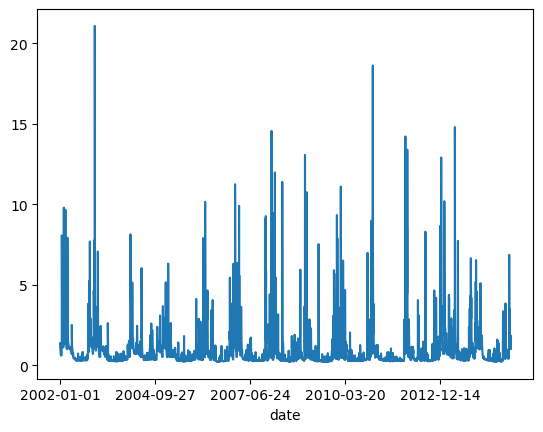

In [161]:
data.Q.plot()
print(data.p_mean.isnull().values.any())
print(data.pet_mean.isnull().values.any())
print(data.t_mean.isnull().values.any())

In [162]:
inputs

{'BEWA0067': [array([0. , 0. , 0. , ..., 1.6, 0. , 0.2]),
  array([-4.5 , -4.06, -5.6 , ..., -3.1 , -0.49,  0.  ]),
  array([0.21, 0.29, 0.2 , ..., 0.28, 0.23, 0.23])],
 'BEWA0087': [array([0. , 0. , 0. , ..., 1.3, 0. , 0.5]),
  array([-5.2 , -6.54, -5.78, ..., -4.09, -0.09,  0.09]),
  array([0.22, 0.29, 0.23, ..., 0.32, 0.26, 0.27])],
 'BEWA0106': [array([0. , 0. , 0. , ..., 1.7, 0. , 0. ]),
  array([-4.71, -5.29, -5.23, ..., -2.81,  0.  ,  0.12]),
  array([0.24, 0.33, 0.19, ..., 0.32, 0.26, 0.28])],
 'BEWA0107': [array([0.  , 0.  , 0.  , ..., 1.77, 0.  , 0.47]),
  array([-4.16, -4.17, -5.08, ..., -2.71, -0.11,  0.19]),
  array([0.23, 0.32, 0.2 , ..., 0.31, 0.25, 0.26])],
 'DERP2005': [array([0.  , 0.  , 0.  , ..., 1.68, 0.  , 0.  ]),
  array([-4.75, -5.36, -5.26, ..., -2.84, -0.03,  0.11]),
  array([0.23, 0.33, 0.19, ..., 0.32, 0.26, 0.27])],
 'DERP2006': [array([0.  , 0.  , 0.  , ..., 1.56, 0.  , 0.14]),
  array([-4.63, -4.54, -5.56, ..., -3.09, -0.41,  0.04]),
  array([0.21, 0.28, 

In [163]:
# Python implementation
from david2022 import FastReservoirPower, FastReservoirLinear
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [164]:
#root_finder = PegasusPython()
#num_app = ImplicitEulerPython(root_finder=root_finder)

root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'split-par']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter_low = ParameterizedSingleFluxSplitter(
    parameters={'split-par': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'split-par': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'split-par': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 50.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

general_low = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter_low],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='M4'
)

general_high = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter_high],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='M4'
)

general_medium = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter_medium],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='M4'
)

In [110]:
DERP2004 = Node(
    units=[general_low],
    weights=[1.0],
    area=615.0,
    id='DERP2004'
)

FR003237 = Node(
    units=[general_low],
    weights=[1.0],
    area=1218.14,
    id='FR003237'
)

FR003253 = Node(
    units=[general_low],
    weights=[1.0],
    area=1102.95,
    id='FR003253'
)

FR003249 = Node(
    units=[general_low],
    weights=[1.0],
    area=3396.832,
    id='FR003249'
)

LU000007 = Node(
    units=[general_low],
    weights=[1.0],
    area=1115.773,
    id='LU000007'
)


catchments = [FR003237, DERP2004, FR003253, FR003249, LU000007]

model = Network(
    nodes=[
        DERP2004,
        FR003237,
        FR003253,
        FR003249,
        LU000007
    ],
    topology={
        'DERP2004': None,
        'FR003237': 'FR003249',
        'FR003253': None,
        'FR003249':None,
        'LU000007':None,

    }
)

In [111]:
areas

{'DEBU1958': 23800.0,
 'FR003272': 9391.476,
 'DEBU1957': 6970.0,
 'DERP2003': 3250.0,
 'FR003308': 1166.52,
 'FR003283': 1241.962,
 'FR003253': 1102.95,
 'FR003271': 926.743,
 'DERP2033': 377.0,
 'DERP2017': 102.0,
 'FR003304': 1812.605,
 'DERP2007': 576.0}

In [162]:
# Method 1: Using Curly Braces {}
units_list = {
    "FR003237": [general_medium],
    "DERP2004": [general_low],
    "FR003253": [general_high],
    "DERP2007": [general_low],
    "LU000007": [general_medium]
}


units_list["FR003237"]



[Module: superflexPy
 Unit: M4
 Layers:
 	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['lowersplitter'], ['slow', 'lag-fun'], ['lower-transparent', 'fast'], ['lower-junction']]
 ********************
 Module: superflexPy
 Element: upper-splitter
 Weight:
 	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
 Direction:
 	[[0, 1, None], [2, None, None]]
 
 ********************
 Module: superflexPy
 Element: snow
 Parameters:
 	M4_snow_t0 : 0.0
 	M4_snow_k : 0.01
 	M4_snow_m : 2.0
 States:
 	M4_snow_S0 : 0.0
 
 ********************
 Module: superflexPy
 Element: upper-transparent
 
 ********************
 Module: superflexPy
 Element: upper-junction
 Direction:
 	[[0, None], [None, 0]]
 
 ********************
 Module: superflexPy
 Element: unsaturated
 Parameters:
 	M4_unsaturated_Smax : 50.0
 	M4_unsaturated_Ce : 1.0
 	M4_unsaturated_m : 0.01
 	M4_unsaturated_beta : 2.0
 States:
 	M4_unsaturated_S0 : 10.0
 
 ********************
 Module: superflexPy
 Element: l

In [163]:
units_list

{'FR003237': [Module: superflexPy
  Unit: M4
  Layers:
  	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['lowersplitter'], ['slow', 'lag-fun'], ['lower-transparent', 'fast'], ['lower-junction']]
  ********************
  Module: superflexPy
  Element: upper-splitter
  Weight:
  	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
  Direction:
  	[[0, 1, None], [2, None, None]]
  
  ********************
  Module: superflexPy
  Element: snow
  Parameters:
  	M4_snow_t0 : 0.0
  	M4_snow_k : 0.01
  	M4_snow_m : 2.0
  States:
  	M4_snow_S0 : 0.0
  
  ********************
  Module: superflexPy
  Element: upper-transparent
  
  ********************
  Module: superflexPy
  Element: upper-junction
  Direction:
  	[[0, None], [None, 0]]
  
  ********************
  Module: superflexPy
  Element: unsaturated
  Parameters:
  	M4_unsaturated_Smax : 50.0
  	M4_unsaturated_Ce : 1.0
  	M4_unsaturated_m : 0.01
  	M4_unsaturated_beta : 2.0
  States:
  	M4_unsaturated_S0 : 10.0
  

In [165]:
# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:
    node = Node(
        units=[general_low],  # Use unit from dictionary or default
        weights=[1.0],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    globals()[cat_id] = node

In [ ]:
"FR003237" # Epinal
"FR003249" # Toul
"FR003253" # Luneville
"FR000159" # Malzeville 
"FR003265" # Custines
"FR003271" # Nomeny
"FR000171" # Metz
"FR003272" # Hanconcourt
"FR003283" # Rosselange
"FR003275" # Boncourt
"DEBU1956" # Perl
"DEBU1957" #Fremersdorf
"FR003308" #Niedaltdorf
"FR003301" # Wittring
"FR003304" # Bliesbruck
"LU000007" #Ettelbruck
"DERP2004" # GemuendOur
"DERP2017" # Hentern
"DEBU1958" # Trier
"DERP2024" # Kordel
"DERP2033" # Plein
"DEBU1959" # Cochem
"DERP2011" #Alsdorf 
"DERP2003" # Bollendorf
"DERP2007" # Pruem

# Nalbach MISSING
# Reinheim MISSING

In [ ]:
topology_list={
        'FR003237': 'FR003249',
        'FR003249': 'FR003265',
        'FR003253': 'FR000159',
        'FR000159': 'FR003265', 
        'FR003271': 'FR000171',
        'FR003265': 'FR003272',
        'FR003271': 'FR000171',
        'FR003272': 'DEBU1956',
        'FR003275': 'FR003283',
        'FR003283': 'DEBU1956',
        'FR003301': 'DEBU1957',
        'DERP2017': 'DEBU1959',
        'DERP2033': 'DEBU1959',
        'DEBU1959': None,
        'DEBU1957': 'DEBU1958',
        'DEBU1956': 'DEBU1958',
        'DERP2024': 'DEBU1959',
        'DERP2003': 'DEBU1958',
        'DERP2011': 'DEBU1958',
        'DERP2007': 'DEBU1958',
        'DERP2004': 'DERP2003',
        'LU000007': 'DERP2003',
        'DEBU1958': 'DEBU1959',
        'FR003304': 'DEBU1957',
        'FR003308': 'DEBU1957',
        'FR000171': 'FR003272'}

In [114]:
# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)

In [166]:
# Create the Network for when there is no topology defined:
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology={cat_id: None for cat_id in catchments_ids}  # Simple topology (no upstream)
)

In [ ]:
# Group 1:
# Whole network:
model = Network(
    nodes=[
        FR003237,
        FR003249,
        FR003253,
        FR000159, 
        FR003271,
        FR003265,
        FR003271,
        FR003272,#
        FR003275,
        FR003283,#
        FR003301,
        DERP2017,
        DERP2033,
        DEBU1959,
        DEBU1957,#
        DEBU1956,
        DERP2024,
        DERP2003,#
        DERP2011,
        DERP2007,
        DERP2004,
        LU000007,
        DEBU1958,#
        FR003304,
        FR003308,#
        FR000171,
    ],
    topology={
        'FR003237': 'FR003249',
        'FR003249': 'FR003265',
        'FR003253': 'FR000159',
        'FR000159': 'FR003265', 
        'FR003271': 'FR000171',
        'FR003265': 'FR003272',
        'FR003271': 'FR003272',
        'FR003272': 'DEBU1956',#
        'FR003275': 'FR003283',
        'FR003283': 'DEBU1956',#
        'FR003301': 'DEBU1957',
        'DERP2017': 'DEBU1959',
        'DERP2033': 'DEBU1959',
        'DEBU1959': None,
        'DEBU1957': 'DEBU1958',#
        'DEBU1956': 'DEBU1958',
        'DERP2024': 'DEBU1959',
        'DERP2003': 'DEBU1958',#
        'DERP2011': 'DEBU1958',
        'DERP2007': 'DEBU1958',
        'DERP2004': 'DERP2003',
        'LU000007': 'DERP2003',
        'DEBU1958': 'DEBU1959',#
        'FR003304': 'DEBU1957',
        'FR003308': 'DEBU1957',#
        'FR000171': 'FR003272',
    }
)

In [167]:
areas.keys()

dict_keys(['BEWA0067', 'BEWA0087', 'BEWA0106', 'BEWA0107', 'DERP2005', 'DERP2006', 'DERP2008', 'DERP2013', 'DERP2016', 'DERP2028', 'DERP2030', 'DERP2031', 'DERP2036', 'FR000124', 'FR000132', 'FR000137', 'FR000144', 'FR000169', 'FR000174', 'FR000183', 'FR000184', 'FR000201', 'FR003234', 'FR003239', 'FR003250', 'FR003266', 'FR003267', 'FR003268', 'FR003294', 'FR003303', 'FR003306', 'LU000002', 'LU000010', 'LU000018'])

In [168]:
# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs

In [169]:
import numpy as np
import spotpy

class spotpy_model(object):

    def __init__(self, model, catchments, dt, observations, parameters, parameter_names, output_index, warm_up=365):

        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            model (Network): SuperflexPy network containing multiple nodes.
            catchments (list): List of Node objects.
            inputs (dict): Dictionary with inputs for each node.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._model = model  # The SuperflexPy network
        self._catchments = catchments  # List of catchments
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names

        # Store inputs and observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the entire network using the same parameter set and collects per-node outputs."""

        # Convert parameter list into a dictionary
        named_parameters = {p_name: p for p_name, p in zip(self._parameter_names, parameters)}

        # Apply shared parameters to the whole network
        self._model.set_parameters(named_parameters)

        # Set timestep and reset the network
        self._model.set_timestep(self._dt)
        self._model.reset_states()

        # Run the full network
        output = self._model.get_output()  # Get outputs for all nodes

        # Return outputs as a list (one per node)
        return [output[cat.id][self._output_index] for cat in self._catchments]

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for sim, cat in zip(simulation, self._catchments):
            node_id = cat.id
            obs = evaluation[node_id]

            # Apply warm-up period
            sim = sim[self._warm_up + 1:]
            obs = obs[self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error

In [170]:
spotpy_hyd_mod = spotpy_model(
    model=model,  # The entire SuperflexPy network
    catchments=catchments,  # Use predefined catchments list
    dt=1.0,  # Time step
    observations=observations,  # Observed data per node
    parameters=[
        spotpy.parameter.Uniform("M4_fast_k", 1e-5, 1.0),
        spotpy.parameter.Uniform("M4_slow_k", 1e-8, 0.1),
        spotpy.parameter.Uniform("M4_unsaturated_Ce", 0.1, 3.0),
        spotpy.parameter.Uniform("M4_unsaturated_m", 0.01, 1.0),
        spotpy.parameter.Uniform("M4_unsaturated_beta", 0.1, 10.0),
        #spotpy.parameter.Uniform("M4_lowersplitter_split-par", 0.5, 0.9),
        spotpy.parameter.Uniform("M4_lag-fun_lag-time", 1.0, 4.0),
    ],
    parameter_names=[
        "M4_fast_k", "M4_slow_k", "M4_unsaturated_Ce", "M4_unsaturated_m",
        "M4_unsaturated_beta", "M4_lag-fun_lag-time",
        #"M4_lowersplitter_split-par"
    ],
    output_index=0,  # Assumes all nodes have the same output variable
    warm_up=365  # Warm-up period
)

In [171]:
#sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat="ram", parallel="seq")

sampler.sample(repetitions=100)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
2 of 100, minimal objective function=1.95799, time remaining: 00:01:39
4 of 100, minimal objective function=1.95799, time remaining: 00:01:51
6 of 100, minimal objective function=1.12836, time remaining: 00:01:55
8 of 100, minimal objective function=1.12836, time remaining: 00:01:56
10 of 100, minimal objective function=1.12836, time remaining: 00:01:55
12 of 100, minimal objective function=1.12836, time remaining: 00:01:55
14 of 100, minimal objective function=1.12836, time remaining: 00:01:54
16 of 100, minimal objective function=1.12836, time remaining: 00:01:53
18 of 100, minimal objective function=1.12836, time remaining: 00:01:53
20 of 100, minimal objective function=1.12836, time remaining: 00:01:51
22 of 100, minimal objective function=1.12836, time r

The figure as been saved as "Parameter_trace.png
Run number 5 has the lowest objectivefunction with: 1.1284


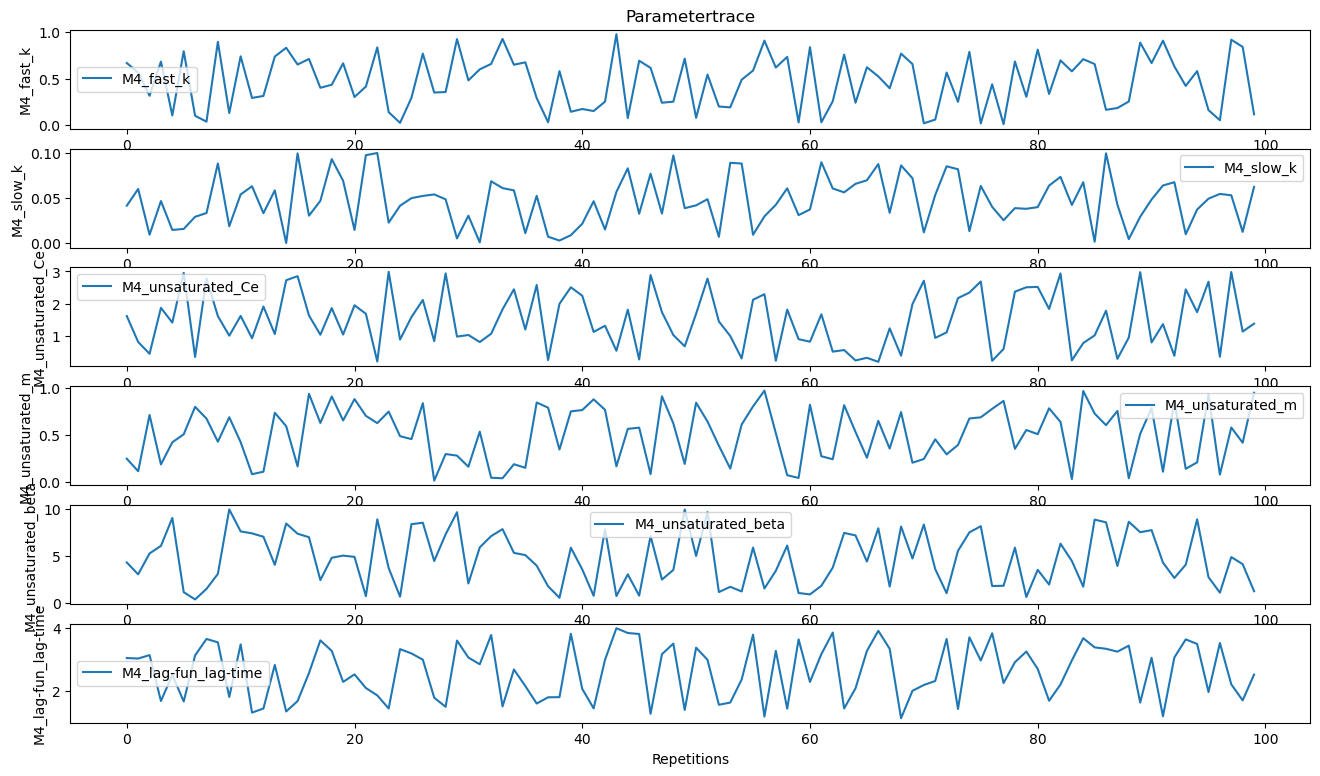

In [172]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function


spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')


# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

In [173]:
model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


#best_params_dict['M4_lowersplitter_split-par'] = 0.5


model.set_timestep(1.0)
model.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = model.get_output()
output

{'BEWA0067': [array([0.        , 0.        , 0.        , ..., 1.10780335, 0.96301323,
         0.88926063])],
 'BEWA0087': [array([0.        , 0.        , 0.        , ..., 0.84194905, 0.78832604,
         0.78998284])],
 'BEWA0106': [array([0.        , 0.        , 0.        , ..., 0.84753049, 0.73574768,
         0.67680903])],
 'BEWA0107': [array([0.        , 0.        , 0.        , ..., 1.12846837, 1.00024096,
         0.97697523])],
 'DERP2005': [array([0.        , 0.        , 0.        , ..., 0.84699017, 0.73368509,
         0.67416265])],
 'DERP2006': [array([0.        , 0.        , 0.        , ..., 1.02296894, 0.88359722,
         0.82529704])],
 'DERP2008': [array([0.        , 0.        , 0.        , ..., 0.82804901, 0.7045732 ,
         0.64135751])],
 'DERP2013': [array([0.        , 0.        , 0.        , ..., 1.16470467, 0.7567221 ,
         0.6020342 ])],
 'DERP2016': [array([0.        , 0.        , 0.        , ..., 1.12799794, 0.81307679,
         0.68507577])],
 'DERP2028

In [174]:
for basin in areas.keys():
    Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    print(basin, 1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))

BEWA0067 0.6101129525132121
BEWA0087 -15.974138655864504
BEWA0106 0.5449137666579934
BEWA0107 0.5898272238573945
DERP2005 0.5911061073755501
DERP2006 0.6045453735471655
DERP2008 0.6172449583625068
DERP2013 -0.769527150440344
DERP2016 0.5702496243169264
DERP2028 0.5951883535528633
DERP2030 0.5349034292741824
DERP2031 0.561294119941002
DERP2036 0.5418548887192749
FR000124 0.613585877455382
FR000132 0.4208309949077913
FR000137 0.6935906343361022
FR000144 -0.9785719814164482
FR000169 0.6368190835033174
FR000174 0.5016853864806154
FR000183 0.41902224545716693
FR000184 -0.27444611752775194
FR000201 0.5459525520836124
FR003234 0.2716065935657851
FR003239 0.7062766922837449
FR003250 -0.20118947707891044
FR003266 0.3013522988885069
FR003267 0.46369649863295925
FR003268 0.5721215217999038
FR003294 0.6426272636999206
FR003303 -0.43404332337615514
FR003306 -0.9303563654177258
LU000002 0.6857723670261715
LU000010 0.6884643462343123
LU000018 0.664148992216399


In [123]:
#catchments_ids = estreams_attributes_clipped[estreams_attributes_clipped.gauges_upstream <= 1].index.tolist()
catchments_ids = ["FR003237", # Epinal
                  "FR003249", # Toul
                  "FR000159", # Malzeville 
                  "FR003265", # Custines
                    "FR000171", # Metz
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "FR003301", # Wittring
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2024", # Kordel
                    "DEBU1959", # Cochem
                    "DERP2011"] #Alsdorf 


# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:
    node = Node(
        units=[general_low],  # Use unit from dictionary or default
        weights=[1.0],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    globals()[cat_id] = node

    
# Initialize the dictionary
inputs = {}
observations = {}
areas = {}

for basin_id in catchments_ids:
    
    data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    #data = data.loc["1988":"2001", :]
    data = data.loc["2002":"2015"]

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area


# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)

model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


#best_params_dict['M4_lowersplitter_split-par'] = 0.5


model.set_timestep(1.0)
model.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = model.get_output()
output



{'FR003237': [array([0.        , 0.        , 0.        , ..., 1.55921675, 1.38562555,
         1.26730664])],
 'FR000159': [array([0.        , 0.        , 0.        , ..., 2.18857568, 1.56693254,
         1.22397401])],
 'FR003275': [array([0.        , 0.        , 0.        , ..., 2.28285863, 1.66245826,
         1.31932884])],
 'FR003301': [array([0.        , 0.        , 0.        , ..., 2.40988788, 1.67210658,
         1.27660444])],
 'DEBU1956': [array([0.        , 0.        , 0.        , ..., 2.30375311, 1.64182534,
         1.28014572])],
 'DERP2024': [array([0.        , 0.        , 0.        , ..., 1.54187761, 1.27783449,
         1.11204789])],
 'DERP2011': [array([0.        , 0.        , 0.        , ..., 1.56024593, 1.28657454,
         1.11436322])],
 'DERP2004': [array([0.        , 0.        , 0.        , ..., 1.83566845, 1.52735812,
         1.34484032])],
 'LU000007': [array([0.        , 0.        , 0.        , ..., 2.165134  , 1.61060822,
         1.29809316])],
 'FR000171

In [125]:
for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    print(network_estreams.loc[basin, "gauge_name"], basin, 1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))

La Moselle Ã  Ã‰pinal FR003237 0.8244792771459557
La Moselle Ã  Toul FR003249 0.8675276053151244
A6941020 FR000159 0.7634916006896784
La Moselle Ã  Custines FR003265 0.8519876030063785
A7881010 FR000171 0.7680169984957349
L'Orne Ã  Boncourt FR003275 0.659038767127995
BundespegelPerl  DEBU1956 0.8280640364988754
La Sarre Ã  Wittring FR003301 0.803460272171202
EttelbrueckAlzette LU000007 0.7178781357760224
GemuendOur DERP2004 0.7937650378715426
Kordel DERP2024 0.7490344064806858
BundespegelCochem DEBU1959 0.815090938121596
AlsdorfOberecken DERP2011 0.7287496781904007


In [298]:
for basin in areas.keys():
    Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    print(basin, 1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))

FR003237 0.7233558713807696
FR003249 0.7857027176186224
FR003253 0.3878544582627701
FR000159 0.6081680596664203
FR003265 0.7132547232230247
FR003271 0.6637390250040114
FR000171 0.6953316970346151
FR003272 0.691946589157379
FR003283 0.7316089827911934
FR003275 0.7009760159437041
DEBU1956 0.6757108948721947
DEBU1957 0.7483438095953565
FR003308 0.7618494373966822
FR003301 0.7811255177666672
FR003304 0.449355969739905
LU000007 0.7332146572606155
DERP2004 0.7649510673714486
DERP2017 0.6359296340769447
DEBU1958 0.7089337378169949
DERP2024 0.6272714335495646
DERP2033 0.7550015470091432
DEBU1959 0.685422176404427
DERP2011 0.7589612835549371
DERP2003 0.7608982082514891
DERP2007 0.7282897928315735


In [309]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["DERP2033"]
Qtimeseries["Qcalc"] = output["DERP2033"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.842858861105693

<Axes: >

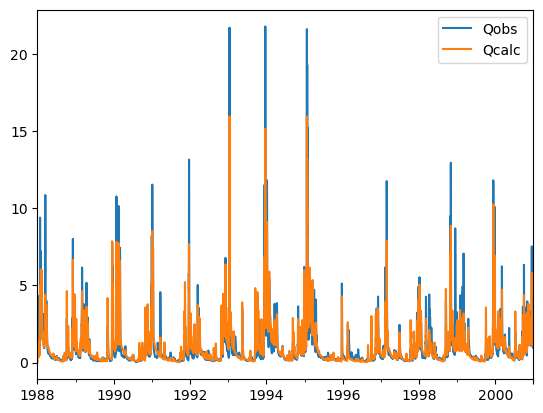

In [310]:
Qtimeseries.plot()

In [301]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003237"]
Qtimeseries["Qcalc"] = output["FR003237"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7233558713807696

<Axes: >

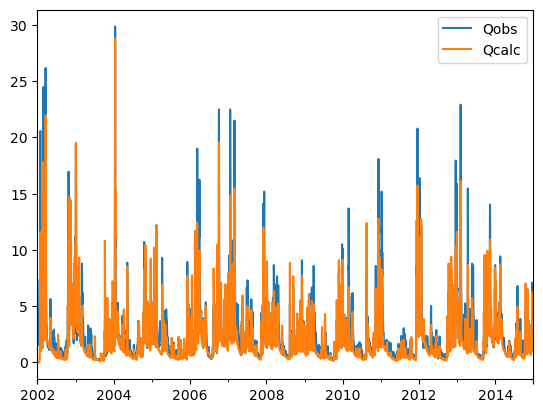

In [302]:
Qtimeseries.plot()

In [234]:
areas

{'FR003237': 1218.14,
 'DERP2004': 615.0,
 'FR003253': 1102.95,
 'FR003249': 3396.832,
 'LU000007': 1115.773}

In [286]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003249"]
Qtimeseries["Qcalc"] = output["FR003249"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7976164883940482

<Axes: >

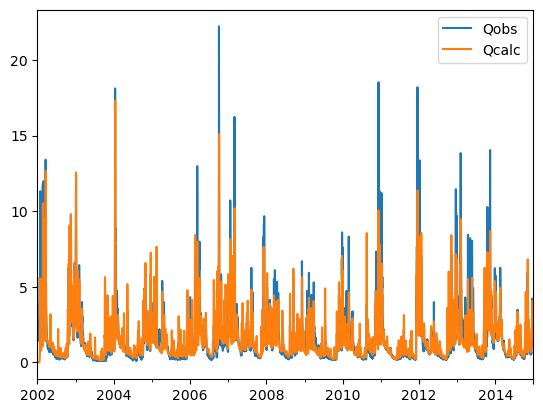

In [287]:
Qtimeseries.plot()

In [288]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.54352649657022

In [289]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["LU000007"]
Qtimeseries["Qcalc"] = output["LU000007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.6551187507433864

0.7380498663278228


<Axes: >

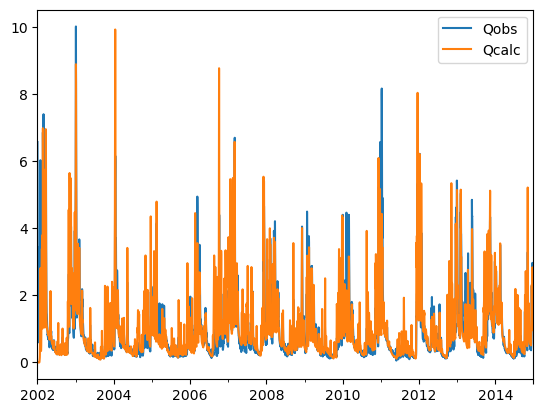

In [292]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DEBU1959"]
Qtimeseries["Qcalc"] = output["DEBU1959"][0]

print(1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))
Qtimeseries.plot()

In [187]:
model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


best_params_dict['M4_lowersplitter_split-par'] = 0.65


model.set_timestep(1.0)
model.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = model.get_output()
output

{'FR003237': [array([0.        , 0.        , 0.        , ..., 1.57438332, 1.47980825,
         1.41788529])],
 'DERP2004': [array([0.        , 0.        , 0.        , ..., 1.9179584 , 1.57526105,
         1.32558672])],
 'FR003253': [array([0.        , 0.        , 0.        , ..., 1.02099612, 1.13402406,
         1.01305816])],
 'DERP2007': [array([0.        , 0.        , 0.        , ..., 1.64363308, 1.36571395,
         1.15799314])],
 'LU000007': [array([0.        , 0.        , 0.        , ..., 1.6860886 , 1.29039931,
         1.13582222])]}

In [188]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

-0.29667524112089794

In [185]:
estreams_attributes.loc["FR003253", "baseflow_index"]

0.642

In [186]:
areas

{'FR003237': 1218.14,
 'DERP2004': 615.0,
 'FR003253': 1102.95,
 'DERP2007': 576.0,
 'LU000007': 1115.773}

In [180]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

-0.29667524112089794

In [181]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DERP2007"]
Qtimeseries["Qcalc"] = output["DERP2007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.4073419927466919

In [182]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["LU000007"]
Qtimeseries["Qcalc"] = output["LU000007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7330260915554658

In [122]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["BEWA0107"]
Qtimeseries["Qcalc"] = output["BEWA0107"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

KeyError: 'BEWA0107'

In [123]:
Qtimeseries.plot()

TypeError: no numeric data to plot

In [ ]:



best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])


In [101]:
results[bestindex]

(0.21799583, 0.26215353, 0.03040796, 1.04298502, 0.30325854, 4.89524188, 0.54104064, 2.96090588, 0., 0., 0., 0., 0., 0., 3.22830274e-09, 3.22830315e-09, 3.22830484e-09, 3.22830484e-09, 3.22830484e-09, 4.83473582e-09, 9.26305152e-09, 9.26305704e-09, 9.26306495e-09, 2.46473382e-07, 2.39202513e-07, 8.67886741e-06, 0.00025929, 0.00404235, 0.0062661, 0.01236216, 0.03278941, 0.1079614, 0.29851124, 1.01452128, 2.670107, 5.14868331, 5.2868262, 2.81678834, 1.59637771, 1.20727177, 1.05250243, 0.91586989, 0.81070585, 0.92893766, 1.27789203, 1.8606845, 2.2005742, 3.47513916, 4.78386541, 6.50633744, 6.62457777, 8.85677967, 9.48615831, 5.56301823, 3.07196287, 2.26184297, 2.09884728, 3.12060445, 6.22657207, 9.48440121, 8.1368917, 5.22019468, 5.7498476, 6.6664143, 8.29846701, 9.32693118, 7.47366003, 4.74975664, 3.63532758, 2.98653908, 2.66623446, 2.47873928, 2.41831956, 2.4250216, 2.48349846, 2.3148532, 2.16848808, 2.0610354, 1.96877264, 1.91439893, 1.95823485, 2.06843085, 2.17012699, 1.94399276, 1.99

In [ ]:



import numpy as np
import spotpy

class spotpy_model(object):

    def __init__(self, catchments, dt, observations, parameters, parameter_names, output_index, warm_up=365):
        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            catchments (list): List of Node objects.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._catchments = catchments  # Use predefined catchments list
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names

        # Store observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the simulation for all nodes using the same parameter set."""

        # Convert parameter list into a dictionary
        named_parameters = {p_name: p for p_name, p in zip(self._parameter_names, parameters)}

        outputs = {}  # Store simulation results for each node

        for cat in self._catchments:  # Iterate over manually defined catchments
            cat.set_parameters(named_parameters)  # Apply shared parameters

            # Generate input data
            P = np.zeros(100)
            P[:10] = np.random.randint(10, size=10)
            P[25:30] = np.random.randint(20, size=5)
            P[40:60] = np.random.randint(5, size=20)
            P[80:83] = np.random.randint(30, 50, size=3)

            E = np.ones_like(P) * 2.0  # Constant PET
            T = (np.random.rand(100) - 0.2) * 20  # Random Temperature

            cat.set_input([P, T, E])  # Directly set input for each node
            cat.set_timestep(self._dt)
            cat.reset_states()  # Reset internal states

            output = cat.get_output()
            outputs[cat.id] = output[self._output_index]  # Store results for each node

        return outputs  # Dictionary with outputs for each node

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for node_id in simulation.keys():
            # Apply warm-up period
            sim = simulation[node_id][self._warm_up + 1:]
            obs = evaluation[node_id][self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error


In [70]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):
        #obj_fun = spotpy.objectivefunctions.rmse(evaluation=evaluation,
        #                                                  simulation=simulation)
        #obj_fun = np.sum(np.sqrt(((simulation - evaluation)**2)/100))
        #obj_fun = obj_fun_nsee(observations = evaluation, simulation = simulation, expo = 0.5)
        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        #obj_fun = obj_fun_kge(observations = evaluation_used, simulation = simulation_used)

        
        return obj_fun

In [71]:
DERP2004.reset_states()

spotpy_hyd_mod = spotpy_model(
    model=DERP2004,
    inputs=[P, T, E],
    dt=1.0,
    observations = Q_obs,
    parameters=[
        spotpy.parameter.Uniform('M4_fast_k', 1e-5, 1.0), #1e-3, 0.5
        #spotpy.parameter.Uniform('M4_fast_alpha', 1.0, 2.0),
        spotpy.parameter.Uniform('M4_slow_k ', 1e-8, 0.1), #0.0001, 1.0
        #spotpy.parameter.Uniform('M4_slow_alpha ', 1, 2),
        #spotpy.parameter.Uniform('M4_unsaturated_Smax', 50, 600), #
        
        spotpy.parameter.Uniform('M4_unsaturated_Ce', 0.1, 3.0),#0.5, 4.0
        spotpy.parameter.Uniform('M4_unsaturated_m', 0.01, 1.0),
        spotpy.parameter.Uniform('M4_unsaturated_beta', 0.1, 10.0),#1.0, 4.0
        spotpy.parameter.Uniform('M4_lowersplitter_split-par', 0.5, 0.9),
        spotpy.parameter.Uniform('M4_lag-fun_lag-time', 1.0, 4.0),
        #spotpy.parameter.Uniform('M4_snow_k', 0.0, 1.0),

    ],
    #parameter_names=['model_FR1_k', 'model_FR1_alpha', 'model_FR1_Ce'],
    parameter_names=['M4_fast_k', 'M4_slow_k', 'M4_unsaturated_Ce', 'M4_unsaturated_m', 'M4_unsaturated_beta',
                     'M4_lowersplitter_split-par', 'M4_lag-fun_lag-time'], #"M4_snow_k"
    output_index=0
)

In [72]:
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler.sample(repetitions=100)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
1 of 100, minimal objective function=0.565567, time remaining: 00:03:14
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
47 of 100, minimal objective function=0.312685, time remaining: 00:00:06
93 of 100, minimal objective function=0.306699, time remaining: 00:00:01
Stopping samplig. Maximum number of repetitions reached already during burn-in
Burn-in sampling completed...
*** OPTIMIZATION SEARCH TERMINATED BECAUSE THE LIMIT
ON THE MAXIMUM NUMBER OF TRIALS 
100
HAS BEEN EXCEEDED.  SEARCH WAS STOPPED AT TRIAL NUMBER:
100
OF THE INITIAL LOOP!
Starting Complex Evolution...
SEARCH WAS STOPPED AT TRIAL NUMBER: 100
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.995276
THE BEST POINT HAS IMPROVED IN LAST 100 LOOPS BY 100000.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 8.34 seconds
Tot

The figure as been saved as "Parameter_trace.png
Run number 2035 has the lowest objectivefunction with: 0.202


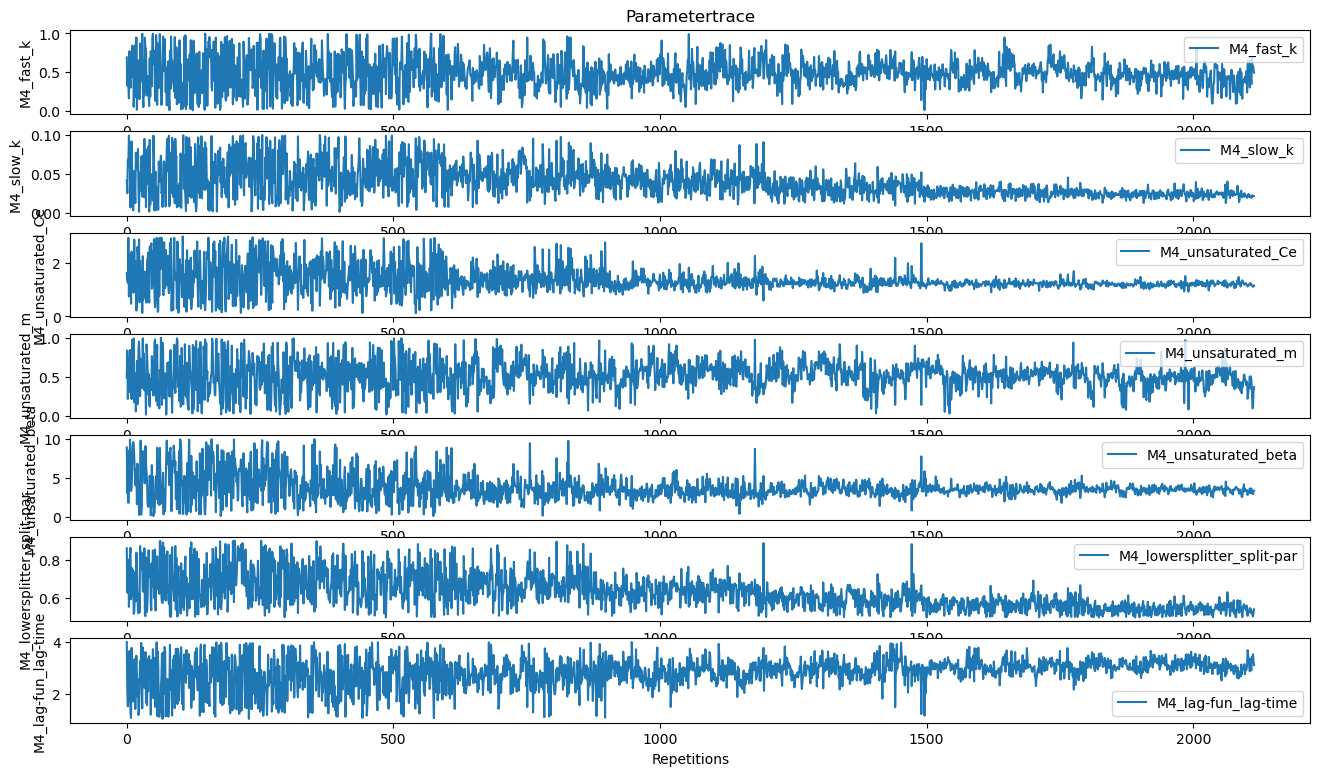

In [622]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function

spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')

# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])

In [623]:
best_model_run

(0.20200061, 0.12008787, 0.0198779, 1.22223028, 0.39998824, 3.19294541, 0.51119517, 3.0028395, 0., 0., 0., 0., 0., 0., 3.54544801e-08, 3.47635228e-08, 3.40862573e-08, 3.34219086e-08, 3.2770507e-08, 5.21709113e-08, 1.08241492e-07, 1.06132973e-07, 1.04066199e-07, 3.37398075e-06, 3.30886324e-06, 8.88586634e-05, 0.00125214, 0.00929014, 0.01743471, 0.04064369, 0.07508837, 0.17258437, 0.39702485, 1.00007245, 2.30194319, 4.51820682, 4.97038484, 2.9338087, 1.72997976, 1.261859, 1.05027737, 0.88472904, 0.75497195, 0.81379401, 1.08079594, 1.55596908, 1.86087039, 2.91158524, 4.13663756, 5.86325392, 6.08912922, 8.20314217, 9.15761393, 5.65865208, 3.11695368, 2.15255576, 1.85928087, 2.58365745, 5.2096476, 8.5270946, 7.75610952, 5.02709266, 5.29747893, 6.00473094, 7.47724821, 8.64316058, 7.13361208, 4.5425116, 3.33914416, 2.61832611, 2.25067126, 2.04148448, 1.96606056, 1.97513781, 2.04646186, 1.91202072, 1.79043339, 1.7035145, 1.63032868, 1.59239431, 1.63681642, 1.75182816, 1.86531227, 1.69845856, 1

In [624]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = best_simulation[365:], expo = 0.5)

0.7985578052913354

In [625]:
1 - obj_fun_kge(observations = Q_obs[365:], simulation = best_simulation[365:])

0.6466534156753938

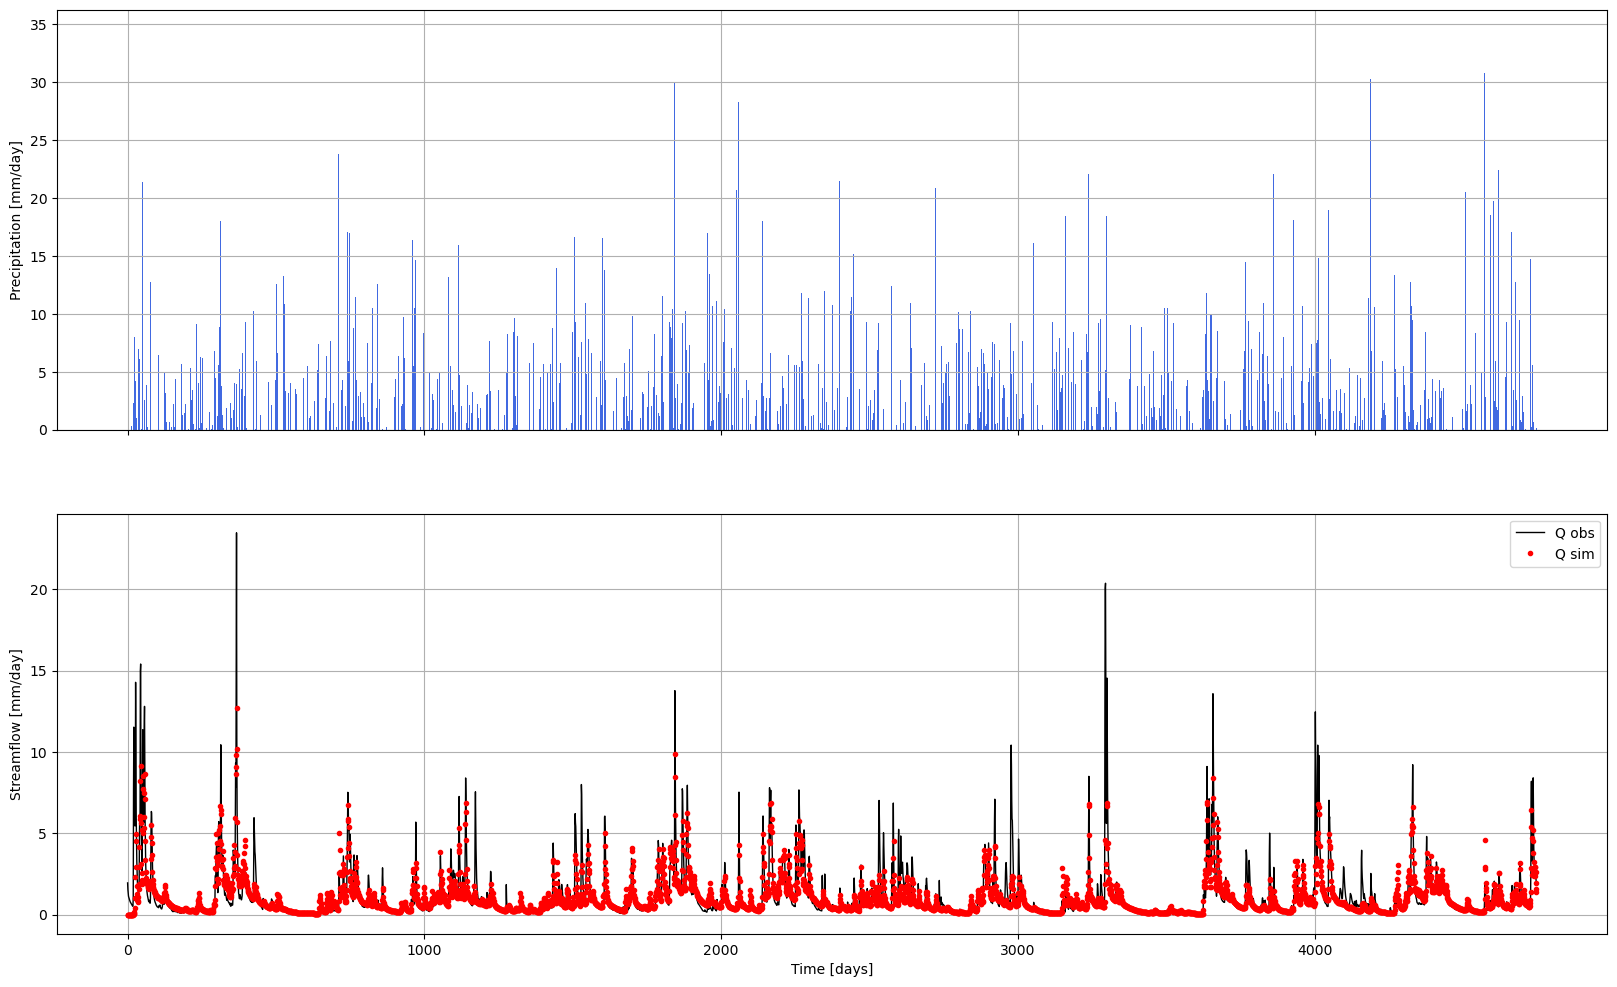

In [626]:
# Plot
fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=1, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), best_simulation,'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

In [627]:
best_params_dict

{'M4_fast_k': 0.1200878726168807,
 'M4_slow_k': 0.0198778976594689,
 'M4_unsaturated_Ce': 1.2222302759799968,
 'M4_unsaturated_m': 0.39998823861160615,
 'M4_unsaturated_beta': 3.1929454065223943,
 'M4_lowersplitter_split-par': 0.5111951674708165,
 'M4_lag-fun_lag-time': 3.0028394978328286}

In [637]:
#best_params_dict['M4_lowersplitter_split-par'] = 0.5
best_params_dict['M4_fast_k'] = 1.0
#best_params_dict['M4_slow_k'] = 0.01
#best_params_dict['M4_snow_k'] = 0.01
#best_params_dict['M4_lag-fun_lag-time'] = 3.0
#best_params_dict['M4_unsaturated_beta'] = 5.0

In [638]:
hyd_mod.reset_states()
hyd_mod.set_input([P,T, E])
hyd_mod.set_timestep(1.0)
hyd_mod.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = hyd_mod.get_output()
output

[array([0.        , 0.        , 0.        , ..., 1.53705382, 1.24153621,
        1.12653391])]

In [639]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

,Qobs,Qcalc
2002-01-01,1.950238,0.000000
2002-01-02,1.534647,0.000000
2002-01-03,1.293373,0.000000
2002-01-04,1.131966,0.000000
2002-01-05,1.063647,0.000000
...,...,...
2014-12-27,2.787952,3.007358
2014-12-28,2.714421,2.524129
2014-12-29,2.269552,1.537054
2014-12-30,2.025230,1.241536


In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2001', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

ValueError: Length of values (4748) does not match length of index (5113)

In [640]:
data_comparation = Qtimeseries.copy()

data_comparation

,Qobs,Qcalc
2002-01-01,1.950238,0.000000
2002-01-02,1.534647,0.000000
2002-01-03,1.293373,0.000000
2002-01-04,1.131966,0.000000
2002-01-05,1.063647,0.000000
...,...,...
2014-12-27,2.787952,3.007358
2014-12-28,2.714421,2.524129
2014-12-29,2.269552,1.537054
2014-12-30,2.025230,1.241536


ValueError: zero-size array to reduction operation fmin which has no identity

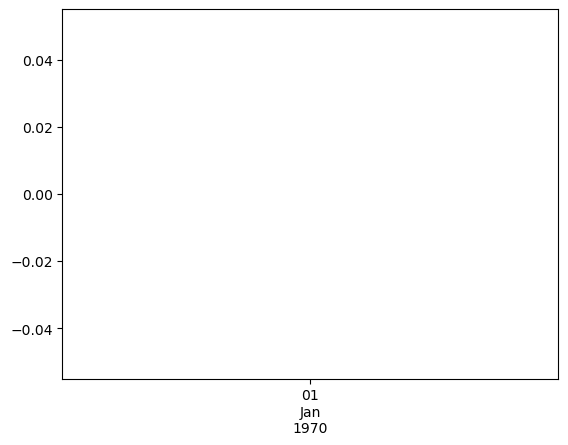

In [641]:
data_comparation.loc["1995-02-01":"1995-06-01"].plot()

<Axes: >

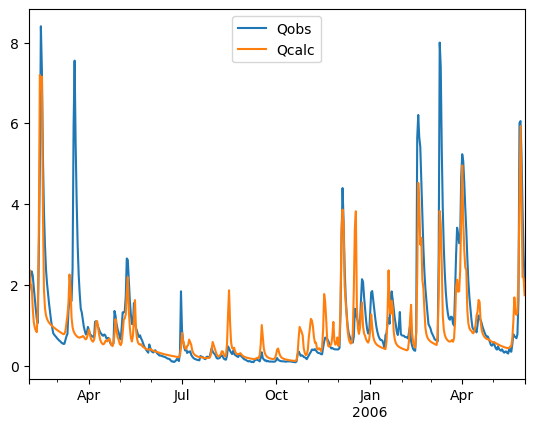

In [642]:
data_comparation.loc["2005-02-01":"2006-06-01"].plot()

In [643]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7803191635265792

In [644]:
network_estreams.loc[basin_id, :]

gauge_id                                                      2626030300
gauge_name                                                    GemuendOur
gauge_country                                                         DE
gauge_provider                                                     DE_RP
river                                                                Our
lon_snap                                                           6.171
lat_snap                                                          49.985
lon                                                                6.171
lat                                                               49.985
elevation                                                            NaN
area_official                                                      613.4
area_estreams                                                      615.0
area_flag                                                              0
area_rel                                           